# Part 1

In [ ]:
import psycopg2
import pandas as pd

# define the connection parameters
dbname = 'everything2024'
user = '' # enter username here
password = '' # enter password here
host = 'pg.mlds.northwestern.edu'
port = '5432' # this is the postgres port


connection = psycopg2.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host,
    port=port
)

In [ ]:
sample_query = """
    SELECT *
    FROM mlds422.movies;  
    """

    # Use pandas to execute the query and load the result into a DataFrame
sampled_df = pd.read_sql_query(sample_query, connection)

In [ ]:
sampled_df

In [ ]:
sampled_df.to_csv('data.csv', index=False)

# Part 2

## Data Cleaning and Preprocessing

In [50]:
import pandas as pd
data = pd.read_csv('data.csv',index_col=None)

In [51]:
data.dtypes

movie_id                int64
movie_title            object
movie_info             object
rating                 object
genre                  object
directors              object
in_theaters_date       object
on_streaming_date      object
runtime_in_minutes    float64
critic_rating           int64
critic_count            int64
audience_rating       float64
audience_count        float64
dtype: object

In [52]:
data.shape

(16638, 13)

In [53]:
rows_with_na = data.isna().any(axis=1).sum()
rows_with_na 
# First we can have a look at the data. There are 16638 rows in total in this dataset and 5292 rows that have NA values in at
# least 1 column. So we cannot just drop them. We need to handle those NA values column by column.

5292

In [54]:
rows_with_na = data[['movie_title', 'movie_id','in_theaters_date', 'on_streaming_date']].isna().any(axis=1).sum()
rows_with_na

815

In [55]:
data = data.dropna(subset=['movie_title', 'movie_id','in_theaters_date', 'on_streaming_date']) 
# First, I would drop those rows that has NA values in movie title or movie id if any, because NA values in these two means we cannot
#identify the movie. Also, i dropped the row that has NA values in in_theaters_date and on_streaming_date. The number of them is not very large
#and it will affect our future analysis. So I just drop them.

In [56]:
rows_with_na = data.isna().any(axis=1).sum()
rows_with_na 

4477

In [57]:
data['rating'] = data['rating'].fillna('Unknown') # Fill with Unknown 
data['genre'] = data['genre'].fillna(data['genre'].mode()[0])  # Fill with most frequent genre

In [58]:
rows_with_na = data.isna().any(axis=1).sum()
rows_with_na


367

In [59]:
# For thse numerial columns, we will fill the missing values with the mean of the column.
data['runtime_in_minutes'].fillna(data['runtime_in_minutes'].mean(), inplace=True)
data['critic_rating'].fillna(data['critic_rating'].mean(), inplace=True)
data['audience_rating'].fillna(data['audience_rating'].mean(), inplace=True)

In [60]:
# For the count of audience and critic, we will just fillin the missing values with 0.
data['audience_count'].fillna(0, inplace=True)
data['critic_count'].fillna(0, inplace=True)

In [61]:
# For these columns with text data, we can fill in missing values with 'Unknown':
data['movie_info'].fillna('Unknown', inplace=True)
data['directors'].fillna('Unknown', inplace=True)

In [62]:
data.shape

(15823, 13)

In [63]:
data[data.isna().any(axis=1)]

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count


In [64]:
data['in_theaters_date'] = pd.to_datetime(data['in_theaters_date'], format='%Y-%m-%d')
data['on_streaming_date'] = pd.to_datetime(data['on_streaming_date'], format='%Y-%m-%d')

## 1

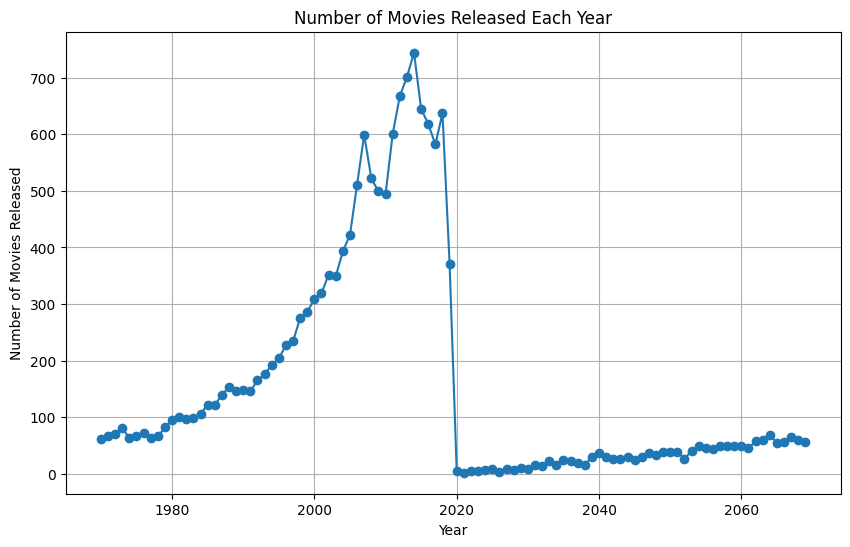

In [65]:
import matplotlib.pyplot as plt
data['release_year'] = pd.to_datetime(data['in_theaters_date'], errors='coerce').dt.year
movies_per_year = data.groupby('release_year').size()


# Visualize the number of movies released each year
plt.figure(figsize=(10, 6))
plt.plot(movies_per_year.index, movies_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.title('Number of Movies Released Each Year')
plt.grid(True)
plt.show()

From this graph, we can see that there the number of movies was low at the start of the time period has increased over time. But after 2019, it has a big decrease from around 600 to less than 100. 
The number of movies has again increased after 2020.  
There are also many data points after this year(2024) and even on around 2040 and 2060. So I searched those movies released after this year and found out that those movies has relase date after 2020 just had release year 100 year later than their actual release year. They are just mislabelled. For example, if the release date of one movie is 2046-01-01 , it is actually released in 1946-01-01. So I would just minus its release year by 100 to get the actual release year and do so for all the data points after 2020.

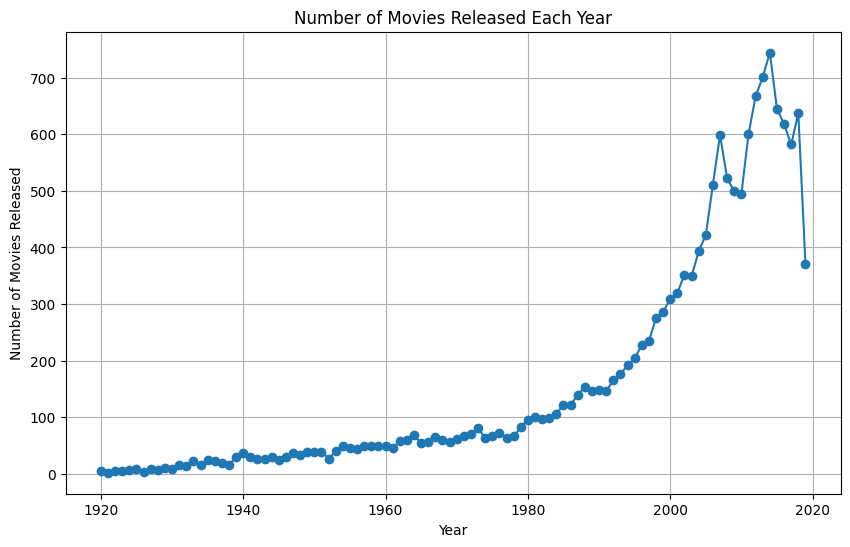

In [66]:
data.loc[data['in_theaters_date'] >= pd.Timestamp('2020-01-01'), 'in_theaters_date'] = data['in_theaters_date'] - pd.DateOffset(years=100)
data['release_year'] = pd.to_datetime(data['in_theaters_date'], errors='coerce').dt.year
movies_per_year = data.groupby('release_year').size()


# Visualize the number of movies released each year
plt.figure(figsize=(10, 6))
plt.plot(movies_per_year.index, movies_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.title('Number of Movies Released Each Year')
plt.grid(True)
plt.show()


In [67]:
data[data['on_streaming_date'].dt.year > 2020]
# I also take a look at the on streaming data column and find that everything looks fine except there is one data point after 2030. Since it's just one data point, I will drop it.

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year
6,7,The 39 Steps,A man in London tries to help a counterespiona...,Unknown,"Action & Adventure, Classics, Mystery & Suspense",Alfred Hitchcock,1935-08-01,2035-06-06,87.0,96,47,86.0,23827.0,1935


In [68]:
data  = data[data['on_streaming_date'].dt.year < 2021]

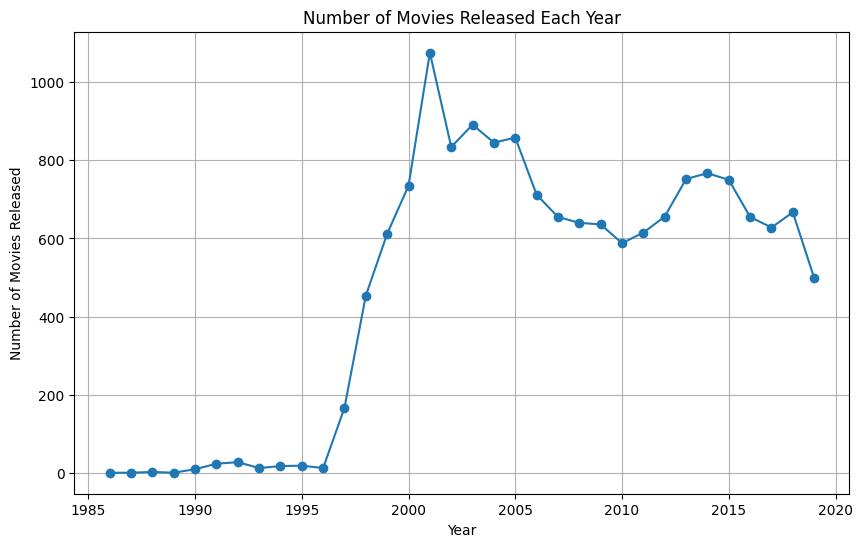

In [69]:
data['release_year_2'] = pd.to_datetime(data['on_streaming_date'], errors='coerce').dt.year
movies_per_year = data.groupby('release_year_2').size()


# Visualize the number of movies released each year
plt.figure(figsize=(10, 6))
plt.plot(movies_per_year.index, movies_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.title('Number of Movies Released Each Year')
plt.grid(True)
plt.show()

## 2

In [70]:
pre_2010_movies = data[data['release_year'] < 2010]

# Find the 5 highest-rated movies by critics
highest_rated_by_critics = pre_2010_movies.nlargest(5, 'critic_rating')
print("Top 5 highest-rated movies by critics before 2010:")
print(highest_rated_by_critics[['movie_title', 'critic_rating']])

# Find the 5 highest-rated movies by the general audience
highest_rated_by_audience = pre_2010_movies.nlargest(5, 'audience_rating')
print("Top 5 highest-rated movies by audience before 2010:")
print(highest_rated_by_audience[['movie_title', 'audience_rating']])
#These top movies don’t seem very popular

Top 5 highest-rated movies by critics before 2010:
                        movie_title  critic_rating
3   12 Angry Men (Twelve Angry Men)            100
14               The Breaking Point            100
15                       Adam's Rib            100
17    The Prowler (Cost of Living )            100
21     The Adventures of Robin Hood            100
Top 5 highest-rated movies by audience before 2010:
                movie_title  audience_rating
222         Prima Ballerina            100.0
1283   La Ciudad (The City)            100.0
1846             Ice People            100.0
3229  Been Rich All My Life            100.0
6747          The Godfather             98.0


## 3

In [71]:
avg_reviews = pre_2010_movies['audience_count'].mean()
popular_movies = pre_2010_movies[pre_2010_movies['audience_count'] > avg_reviews]

# Find the 5 highest-rated popular movies by critics
highest_rated_popular_by_critics = popular_movies.nlargest(5, 'critic_rating')
print("Top 5 highest-rated popular movies by critics before 2010:")
print(highest_rated_popular_by_critics[['movie_title', 'critic_rating']])

# Find the 5 highest-rated popular movies by the general audience
highest_rated_popular_by_audience = popular_movies.nlargest(5, 'audience_rating')
print("Top 5 highest-rated popular movies by audience before 2010:")
print(highest_rated_popular_by_audience[['movie_title', 'audience_rating']])
# Now these top movies make more sense.

Top 5 highest-rated popular movies by critics before 2010:
          movie_title  critic_rating
9636     Mary Poppins            100
11227       Pinocchio            100
13557  The Terminator            100
15439       Toy Story            100
15440     Toy Story 2            100
Top 5 highest-rated popular movies by audience before 2010:
                                          movie_title  audience_rating
6747                                    The Godfather             98.0
12463                        The Shawshank Redemption             98.0
851                                        GoodFellas             97.0
4435                     Cidade de Deus (City of God)             97.0
5706   Star Wars: Episode V - The Empire Strikes Back             97.0


## 4

Percentage of movies by rating:
PG-13      41.475573
R          32.402792
PG         19.641077
G           6.380857
Unknown     0.099701
Name: rating, dtype: float64


<Figure size 1000x600 with 0 Axes>

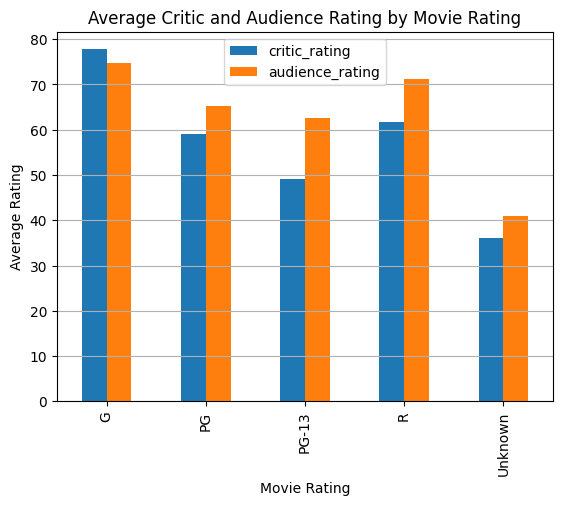

In [72]:
total_movies = popular_movies.shape[0]
rating_counts = popular_movies['rating'].value_counts()
rating_percentages = (rating_counts / total_movies) * 100
print("Percentage of movies by rating:")
print(rating_percentages)

# Create a visualization showing average critic rating and audience rating for each rating
avg_ratings = popular_movies.groupby('rating').agg({'critic_rating': 'mean', 'audience_rating': 'mean'})

plt.figure(figsize=(10, 6))
avg_ratings.plot(kind='bar')
plt.xlabel('Movie Rating')
plt.ylabel('Average Rating')
plt.title('Average Critic and Audience Rating by Movie Rating')
plt.grid(axis='y')
plt.show()


From the summary table we can see that PG-13 rating movies has the highest percentage and the G-rating movies has the lowest percentage.
From the plot we can see that the critic rating and the audience rating are generally higher in G rating movies. 

## 5

<Figure size 1200x1000 with 0 Axes>

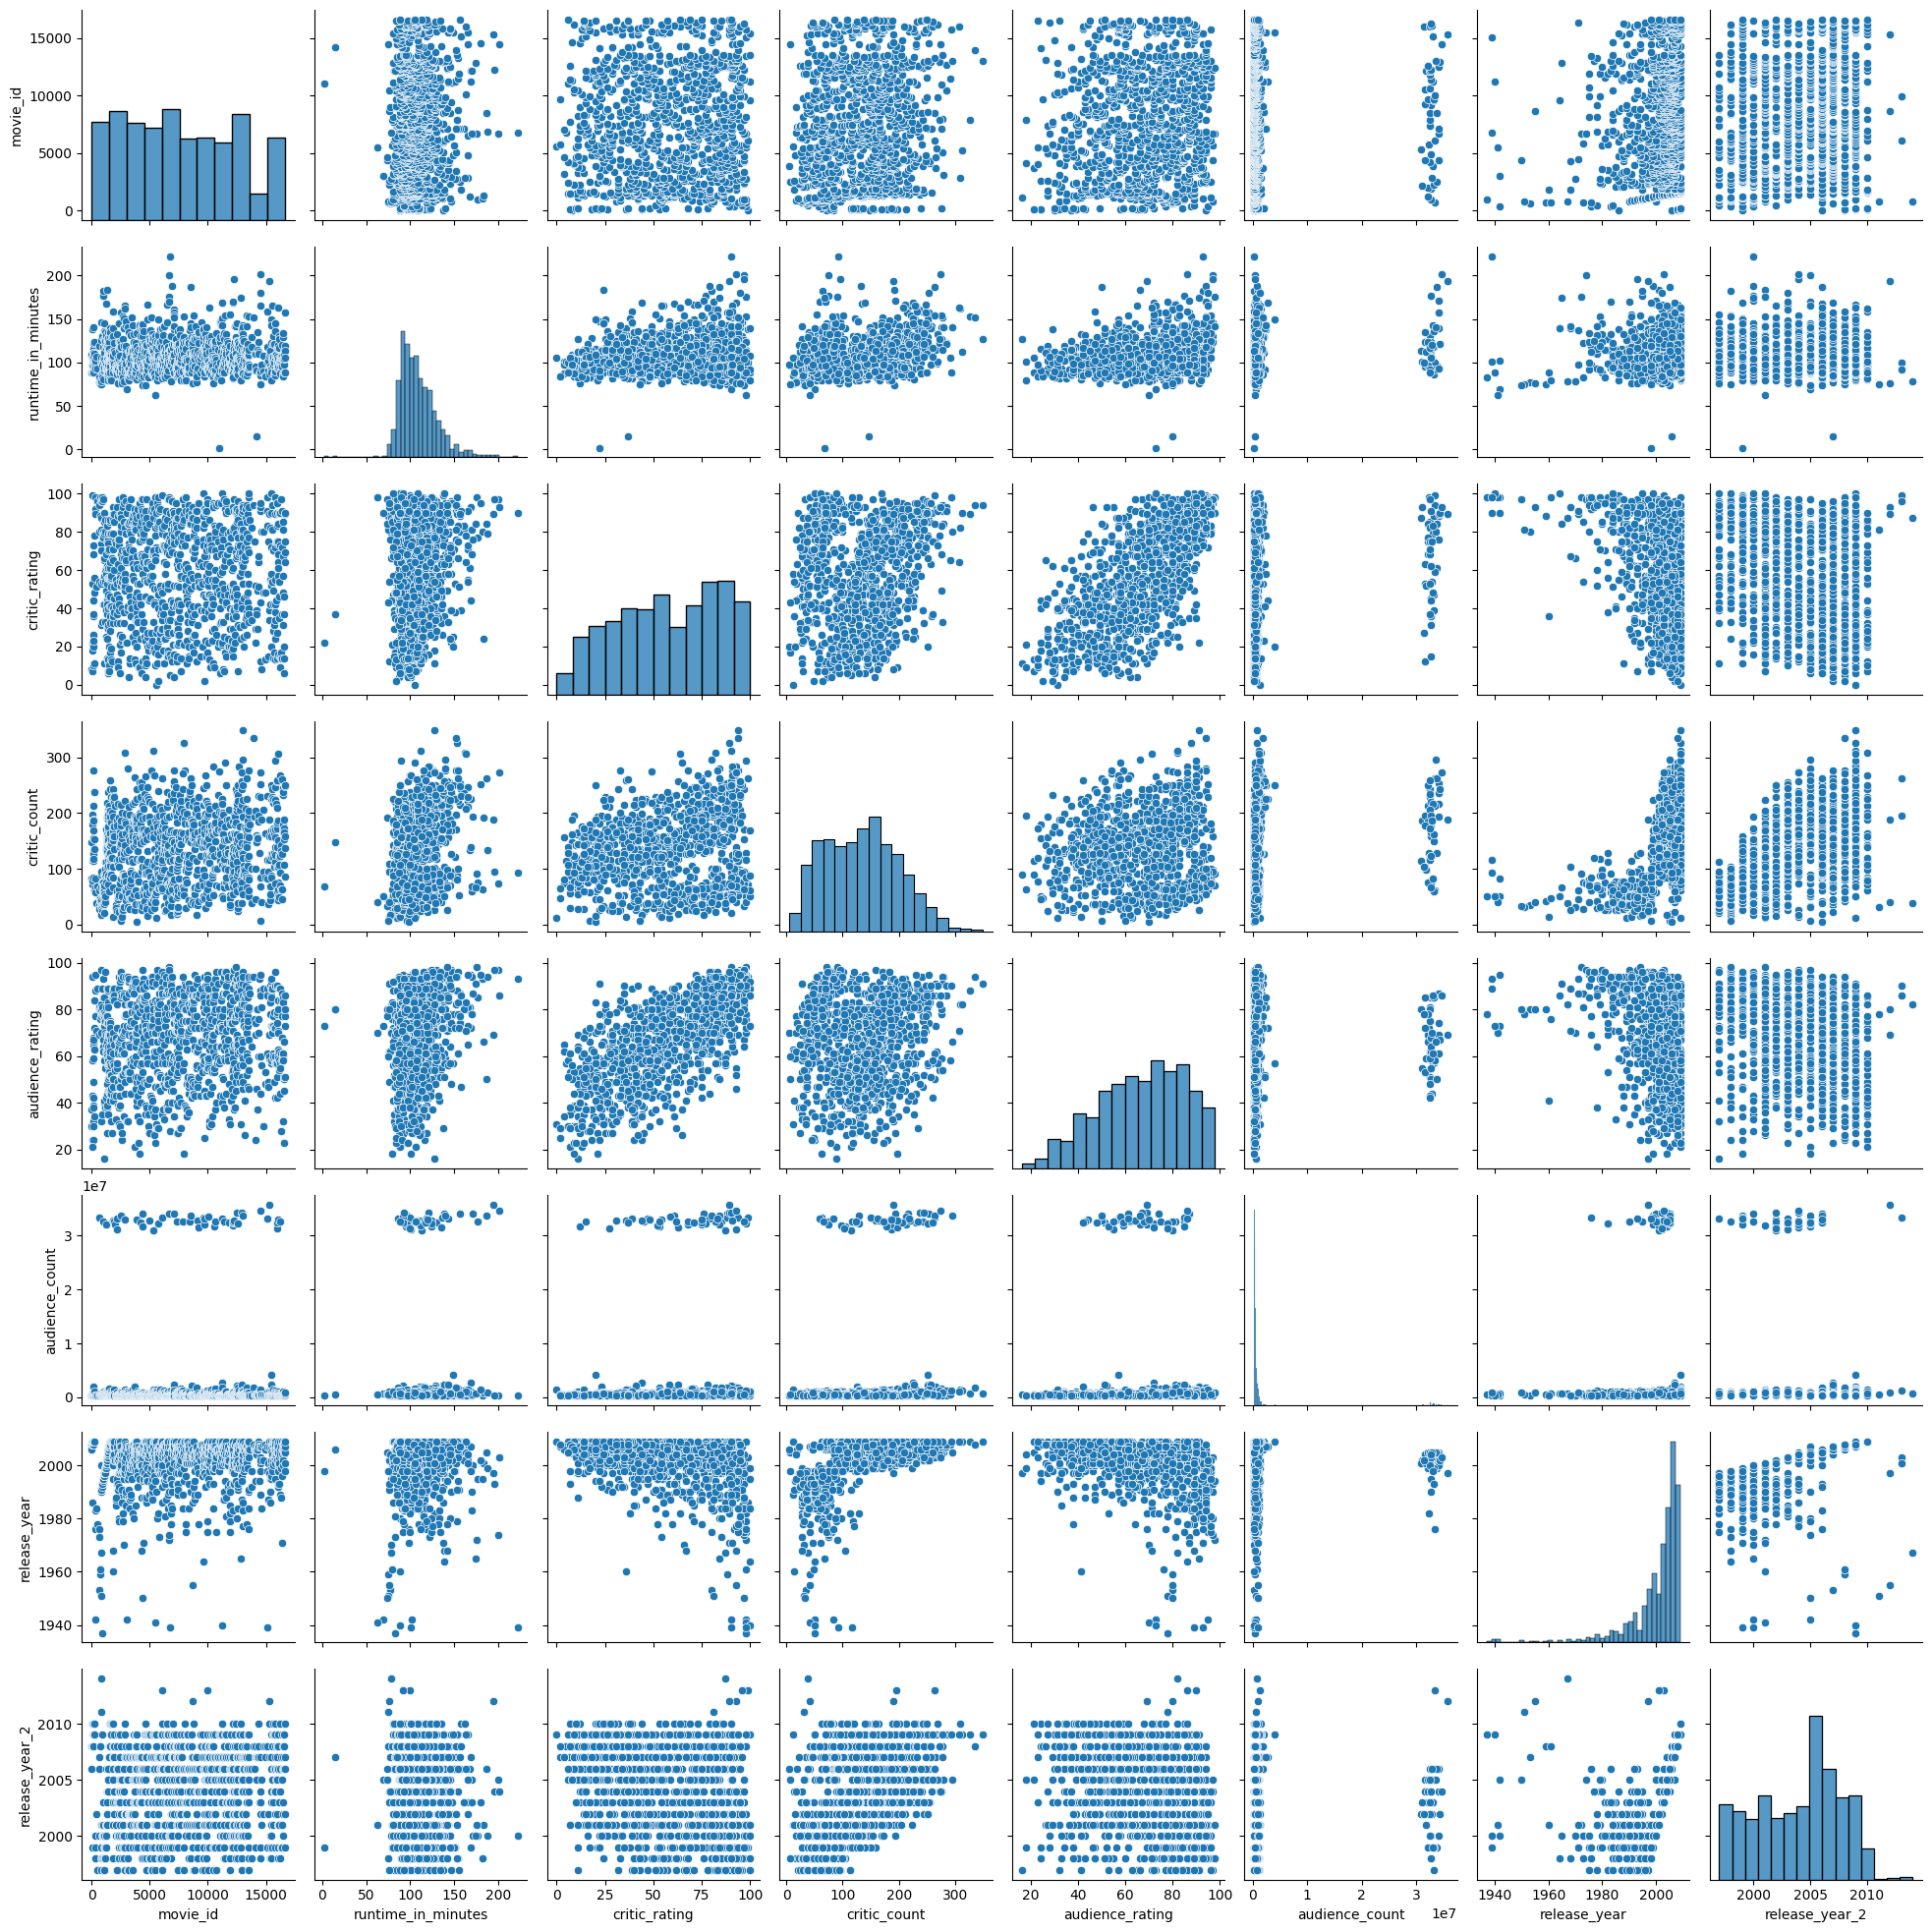

In [73]:
import seaborn as sns
numeric_cols = popular_movies.select_dtypes(include=['number'])  # Select only numeric columns
plt.figure(figsize=(12, 10))
sns.pairplot(numeric_cols)
plt.show()

Three thoughts from the pair plot
Thought 1: There seems to be a positive linear relationship between critic rating and audience rating, meaning that movies that are well-rated by critics tend to also receive good ratings from audiences.
Thought 2: From the pair plot we can see that the runtime in minustes of most movies is around 100-150 minutes.
Thought 3: Those movies with lower audience counts has audience rating widely spread from 0 to 100.Those movies that has more audience genereally has a higher audience rating.

## 6

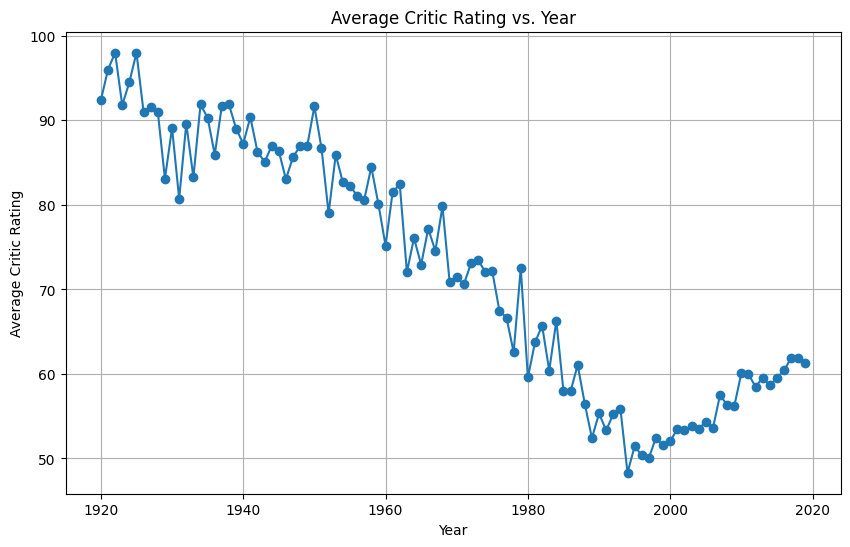

In [74]:
# Group by release year and calculate the average critic rating
avg_critic_rating_by_year = data.groupby('release_year')['critic_rating'].mean().reset_index()

# Plot the average critic rating by year
plt.figure(figsize=(10, 6))
plt.plot(avg_critic_rating_by_year['release_year'], avg_critic_rating_by_year['critic_rating'], marker='o')
plt.xlabel('Year')
plt.ylabel('Average Critic Rating')
plt.title('Average Critic Rating vs. Year')
plt.grid(True)
plt.show()

Thought1: This plot here shows how the average critic_rating of movies released on one year changes over years. We can notice that from 1920 to 1990, the average critic_rating keeps decreasing. But after around 1990, it starts going upward. 

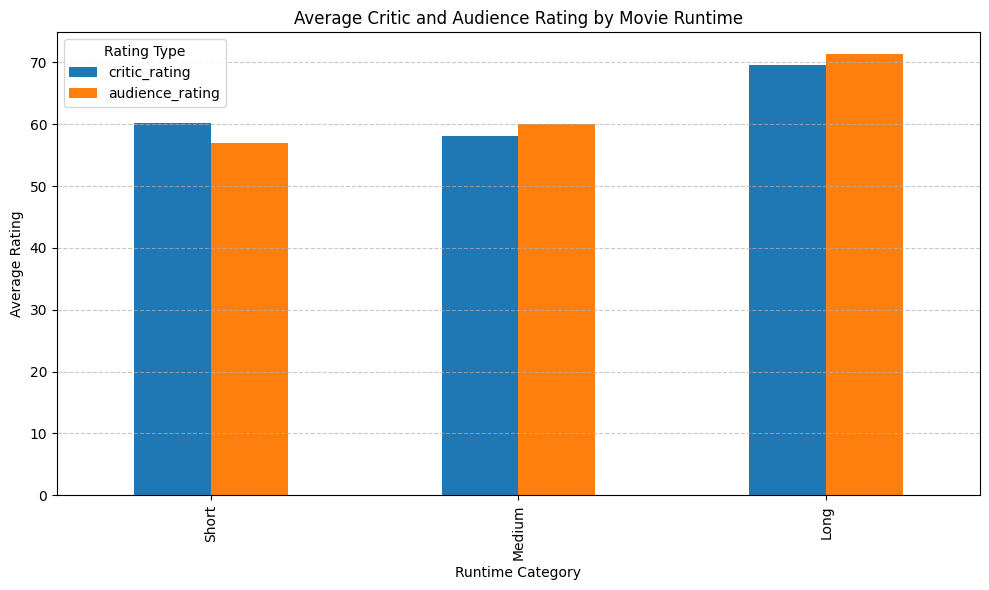

In [75]:
# Create runtime bins (short: <90 min, medium: 90-120 min, long: >120 min)
data['runtime_category'] = pd.cut(data['runtime_in_minutes'], bins=[0, 90, 120, float('inf')], labels=['Short', 'Medium', 'Long'])

# Calculate average audience and critic ratings by runtime category
avg_ratings_by_runtime = data.groupby('runtime_category')[['critic_rating', 'audience_rating']].mean().reset_index()

# Plotting the average audience and critic ratings by runtime category
avg_ratings_by_runtime.plot(x='runtime_category', kind='bar', figsize=(10, 6))

plt.xlabel('Runtime Category')
plt.ylabel('Average Rating')
plt.title('Average Critic and Audience Rating by Movie Runtime')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Rating Type')
plt.tight_layout()

# Show the plot
plt.show()

Thought2: This plot explores the relationship between the movie's runtime in minutes and the average audience_rating and average critic_rating. From this plot, we can see that the average critic rating and average audience rating are both higher for long movies (>120 minutes) than medium or short movies.

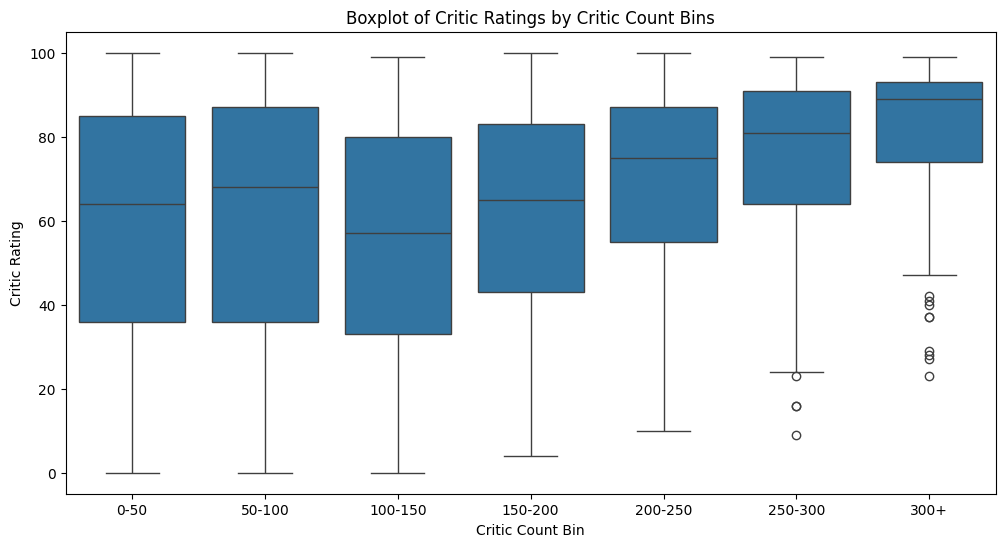

In [76]:


# Create bins for critic_count
data['critic_count_bin'] = pd.cut(data['critic_count'], bins=[0, 50, 100, 150, 200, 250, 300, 500], labels=['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300+'])

# Boxplot of critic ratings by critic count bin
plt.figure(figsize=(12, 6))
sns.boxplot(x='critic_count_bin', y='critic_rating', data=data)
plt.xlabel('Critic Count Bin')
plt.ylabel('Critic Rating')
plt.title('Boxplot of Critic Ratings by Critic Count Bins')
plt.show()

Thought3: This plot shows the realtionship between the critic rating and critic count. The critic rating is generally higher for those movies with higher critic count except for the difference of critic ratings between critic count of 50-100 and 100-150.

## Part 3


## 7

In [77]:
train = data[data['release_year'] < 2010]
test = data[data['release_year'] >= 2010]


## 8

In [78]:
# If our goal is to predict the critic_rating before the first critic or audience rating gets posted for a movie,
# we should not include the critic_rating critic_rating,critic_count,audience_rating,audience_count columns in the train and test dataset.
X_train = train.drop(['critic_rating','critic_count','audience_rating','audience_count'], axis=1)
y_train = train['critic_rating']
X_test = test.drop(['critic_rating','critic_count','audience_rating','audience_count'],  axis=1)
y_test = test['critic_rating']

## 9

In [79]:
new_train = X_train[['movie_title', 'runtime_in_minutes','rating','genre']].copy()

# Add 'kid_friendly' column (assuming 'rating' is the column containing movie ratings)
new_train['kid_friendly'] = new_train['rating'].apply(lambda x: 1 if x in ['G', 'PG'] else 0)

# Create dummy variables for genres 


new_train['genre'] = new_train['genre'].str.split(',').apply(lambda x: ','.join(genre.strip() for genre in x))

# Create dummy variables for genres using cleaned strings
genres_dummies = new_train['genre'].str.get_dummies(sep=',')

new_train = pd.concat([new_train, genres_dummies], axis=1)

## 10

In [80]:
# Belown are the three features that i think will do a good job predicting the critic_rating.

#Decide if the movie is released on theatre during award season
new_train['award_season_release'] = X_train['in_theaters_date'].dt.month.apply(lambda x: 1 if x in [10, 11, 12] else 0)

#Calculate time to streaming (days between theatrical release and streaming release)
new_train['time_to_streaming'] = (X_train['on_streaming_date'] - X_train['in_theaters_date']).dt.days

#Calculate director popularity (frequency of each director in the dataset)
new_train['director_popularity'] = X_train['directors'].map(X_train['directors'].value_counts())

In [81]:
new_train

,movie_title,runtime_in_minutes,rating,genre,kid_friendly,Action & Adventure,Animation,Anime & Manga,Art House & International,Classics,...,Mystery & Suspense,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western,award_season_release,time_to_streaming,director_popularity
2,10,118.0,R,"Comedy,Romance",0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,6536,27
3,12 Angry Men (Twelve Angry Men),95.0,Unknown,"Classics,Drama",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,16033,29
4,"20,000 Leagues Under The Sea",127.0,G,"Action & Adventure,Drama,Kids & Family",1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,18036,16
5,"10,000 B.C.",109.0,PG-13,"Action & Adventure,Classics,Drama",0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,109,8
7,3:10 to Yuma,92.0,Unknown,"Classics,Drama,Western",0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,16309,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16631,Zoolander,105.0,PG-13,"Comedy,Special Interest",0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,165,4
16633,Zoom,88.0,PG,"Action & Adventure,Comedy,Kids & Family",1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,387,4
16635,Zorba the Greek,142.0,Unknown,"Action & Adventure,Art House & International,C...",0,1,0,0,1,1,...,0,0,0,0,0,0,0,1,14474,29
16636,Zulu,139.0,PG,"Classics,Drama",1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,13379,2


In [82]:
new_train = new_train.drop(['rating','genre'], axis = 1)

In [83]:
X_train = new_train

In [84]:
X_train.columns

Index(['movie_title', 'runtime_in_minutes', 'kid_friendly',
       'Action & Adventure', 'Animation', 'Anime & Manga',
       'Art House & International', 'Classics', 'Comedy', 'Cult Movies',
       'Documentary', 'Drama', 'Faith & Spirituality', 'Gay & Lesbian',
       'Horror', 'Kids & Family', 'Musical & Performing Arts',
       'Mystery & Suspense', 'Romance', 'Science Fiction & Fantasy',
       'Special Interest', 'Sports & Fitness', 'Television', 'Western',
       'award_season_release', 'time_to_streaming', 'director_popularity'],
      dtype='object')

# Part 4

## 11

In [85]:
# Make sure that I apply the same transformations on X_test and y_test that i applied on X_train and y_train
new_test = X_test[['movie_title', 'runtime_in_minutes','rating','genre']].copy()

# Add 'kid_friendly' column (assuming 'rating' is the column containing movie ratings)
new_test['kid_friendly'] = new_test['rating'].apply(lambda x: 1 if x in ['G', 'PG'] else 0)

# Create dummy variables for genres 

new_test['genre'] = new_test['genre'].str.split(',').apply(lambda x: ','.join(genre.strip() for genre in x))

# Create dummy variables for genres using cleaned strings
genres_dummies = new_test['genre'].str.get_dummies(sep=',')
new_test = pd.concat([new_test, genres_dummies], axis=1)

# Belown are the three features that i think will do a good job predicting the critic_rating.

#Decide if the movie is released on theatre during award season
new_test['award_season_release'] = X_test['in_theaters_date'].dt.month.apply(lambda x: 1 if x in [10, 11, 12] else 0)

#Calculate time to streaming (days between theatrical release and streaming release)
new_test['time_to_streaming'] = (X_test['on_streaming_date'] - X_test['in_theaters_date']).dt.days

# Calculate director popularity (frequency of each director in the dataset)
new_test['director_popularity'] = X_test['directors'].map(X_test['directors'].value_counts())

new_test = new_test.drop(['rating','genre'], axis = 1)

In [86]:
X_test = new_test

In [87]:
#The number of dummy variables of genre is different in the test and train set , so I fill in 0 for those dummies one dataset has but another doesn't has.

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

## 12 

Now in our train and dataset, there is one column consists of strings which is the movie_title. All the datasets used in the linear regression should only contain 
columns of numeric and non-null values. I would just drop this column in every linear regression below.

In [88]:
X_train[X_train.isna().any(axis=1)]

,movie_title,runtime_in_minutes,kid_friendly,Action & Adventure,Animation,Anime & Manga,Art House & International,Classics,Comedy,Cult Movies,...,Mystery & Suspense,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western,award_season_release,time_to_streaming,director_popularity


In [89]:
X_test[X_test.isna().any(axis=1)]

,movie_title,runtime_in_minutes,kid_friendly,Action & Adventure,Animation,Anime & Manga,Art House & International,Classics,Comedy,Cult Movies,...,Mystery & Suspense,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western,award_season_release,time_to_streaming,director_popularity


In [90]:
y_train.isna().any()

False

In [91]:
y_test.isna().any()

False

## 13

In [92]:
import statsmodels.api as sm

# Model 1: Only runtime_in_minutes
X_train_model1 = X_train[['runtime_in_minutes']]
X_train_model1 = sm.add_constant(X_train_model1)  # Add intercept to the model
model1 = sm.OLS(y_train, X_train_model1).fit()

# Model 2: runtime_in_minutes and kid_friendly
X_train_model2 = X_train[['runtime_in_minutes', 'kid_friendly']]
X_train_model2 = sm.add_constant(X_train_model2)  # Add intercept to the model
model2 = sm.OLS(y_train, X_train_model2).fit()

# Model 3: runtime_in_minutes, kid_friendly, and dummy columns for genres
X_train_model3 = X_train.drop(['time_to_streaming','award_season_release','director_popularity','movie_title'], axis = 1)
X_train_model3 = sm.add_constant(X_train_model3)  # Add intercept to the model
model3 = sm.OLS(y_train, X_train_model3).fit()

# Print summaries of each model for more detailed statistics
print("Model 1 Summary:")
print(model1.summary())

print("\nModel 2 Summary:")
print(model2.summary())

print("\nModel 3 Summary:")
print(model3.summary())


Model 1 Summary:
                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     95.87
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           1.56e-22
Time:                        22:06:32   Log-Likelihood:                -46570.
No. Observations:                9763   AIC:                         9.314e+04
Df Residuals:                    9761   BIC:                         9.316e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              

## 14

In [93]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

# Function to evaluate a model on test data
def evaluate_model(y_test, y_pred):
    # Calculate R^2
    ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
    ss_residual = np.sum((y_test - y_pred) ** 2)
    r_squared = 1 - (ss_residual / ss_total)

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return r_squared, mae, rmse

# Prepare the test data and add constant for the intercept
X_test_model1 = sm.add_constant(X_test[['runtime_in_minutes']])
X_test_model2 = sm.add_constant(X_test[['runtime_in_minutes', 'kid_friendly']])
X_test_model3 = sm.add_constant(X_test.drop([ 'time_to_streaming', 'director_popularity','award_season_release','movie_title'], axis=1))

# Get predictions from each of the models
y_pred_model1 = model1.predict(X_test_model1)
y_pred_model2 = model2.predict(X_test_model2)
y_pred_model3 = model3.predict(X_test_model3)

# Evaluate each model
r2_1, mae_1, rmse_1 = evaluate_model(y_test, y_pred_model1)
r2_2, mae_2, rmse_2 = evaluate_model(y_test, y_pred_model2)
r2_3, mae_3, rmse_3 = evaluate_model(y_test, y_pred_model3)



results = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'R^2': [r2_1, r2_2, r2_3],
    'MAE': [mae_1, mae_2, mae_3],
    'RMSE': [rmse_1, rmse_2, rmse_3]
})

# Display the DataFrame
print(results)



     Model       R^2        MAE       RMSE
0  Model 1  0.001385  24.366118  28.314884
1  Model 2  0.001115  24.403736  28.318721
2  Model 3  0.151455  22.033511  26.100761


## 15

From these three models, we can see that the best model is model3 that includes runtime_in_minutes, kid_friendly and genres_dummies according to Rsquared, MAE and RMSE. According to the p-value from the statsmodels, the runtime_in_minutes, kid_friendly and a couple of dummy variables of genre play a significant role. Among all those significant dummy variables, the Documentary and Classics genres has the most positive significant impacts on the critic rating. The Faith & Spirituality genre has the most negative significant impacts on the critic rating.

## 16

In [94]:
# I include director popularity in this model. I think it could also affect the critic rating. For example, if the director of the movie is popular(has been director of lots of movies in the past), it is more likely that the quality of the movie is better and the critic rating is higher.

X_train_model4 = X_train.drop(['time_to_streaming','award_season_release','movie_title'], axis = 1)
X_train_model4 = sm.add_constant(X_train_model4)  # Add intercept to the model
model4 = sm.OLS(y_train, X_train_model4).fit()
print(model4.summary())

X_test_model4 = sm.add_constant(X_test.drop(['time_to_streaming','award_season_release','movie_title'], axis=1))



y_pred_model4 = model4.predict(X_test_model4)

# Evaluate each model
r2_4, mae_4, rmse_4 = evaluate_model(y_test, y_pred_model4)
print(r2_4, mae_4, rmse_4)

                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     134.7
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:06:32   Log-Likelihood:                -45219.
No. Observations:                9763   AIC:                         9.049e+04
Df Residuals:                    9738   BIC:                         9.067e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [95]:
# From the precious model, we can find out that the performance is not very good. So in this model, I decided to exclude director_popularity. Instead, this model would include 'award_season_release'. 
# I think it would affect the critic rating because movies released in award season are often targeted for awards and therefore may receive higher critic ratings.
X_train_model5 = X_train.drop(['time_to_streaming','director_popularity','movie_title'], axis = 1)
X_train_model5 = sm.add_constant(X_train_model5)  # Add intercept to the model
model5 = sm.OLS(y_train, X_train_model5).fit()
print(model5.summary())

X_test_model5 = sm.add_constant(X_test.drop(['time_to_streaming','director_popularity','movie_title'], axis=1))



y_pred_model5 = model5.predict(X_test_model5)

# Evaluate each model
r2_5, mae_5, rmse_5 = evaluate_model(y_test, y_pred_model5)
print(r2_5, mae_5, rmse_5)

                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     120.2
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:06:32   Log-Likelihood:                -45351.
No. Observations:                9763   AIC:                         9.075e+04
Df Residuals:                    9738   BIC:                         9.093e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [96]:
# The precious model 5 works well. So in this final model I decided to add one more varaible 'time_to_streaming'. Movies with a shorter gap between the in_theaters_date and on_streaming_date may indicate lower popularity, which could correlate with lower critic rating.
X_train_model6 = X_train.drop(['movie_title','director_popularity'], axis = 1)
X_train_model6 = sm.add_constant(X_train_model6)  # Add intercept to the model
model6 = sm.OLS(y_train, X_train_model6).fit()
print(model6.summary())

X_test_model6 = sm.add_constant(X_test.drop(['movie_title','director_popularity'], axis=1))



y_pred_model6 = model6.predict(X_test_model6)

# Evaluate each model
r2_6, mae_6, rmse_6 = evaluate_model(y_test, y_pred_model6)
print(r2_6, mae_6, rmse_6)

                            OLS Regression Results                            
Dep. Variable:          critic_rating   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     154.9
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:06:32   Log-Likelihood:                -44983.
No. Observations:                9763   AIC:                         9.002e+04
Df Residuals:                    9737   BIC:                         9.021e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [97]:

results = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3','Model 4', 'Model 5', 'Model 6'],
    'R^2': [r2_1, r2_2, r2_3, r2_4, r2_5, r2_6],
    'MAE': [mae_1, mae_2, mae_3,mae_4,mae_5, mae_6],
    'RMSE': [rmse_1, rmse_2, rmse_3,rmse_4, rmse_5, rmse_6]
})
print(results)

     Model       R^2        MAE       RMSE
0  Model 1  0.001385  24.366118  28.314884
1  Model 2  0.001115  24.403736  28.318721
2  Model 3  0.151455  22.033511  26.100761
3  Model 4  0.129176  22.379017  26.441193
4  Model 5  0.152226  22.023113  26.088909
5  Model 6  0.123104  22.567372  26.533208


## 17


Out of all six models, we can see it's that the model 5 is the best model according to Rsquared, MAE and RMSE although the differnce between this one and the second place (model 3) is really small. According to the p-values, the runtime_in_minutes, kid_friendly ,director_popularity, award_season_release, time_to_streaming and a couple of dummy variables of genre all have a significant role in predicting critic_rating. Among all those significant dummy variables, the Documentary and Classics genre has the most positive siginificant impacts on the critic rating. The Faith & Spirituality genre has the most negative significant impacts on the critic rating.

## 18

Thought1:We can also include movie_info as one feature and I do think this would also affect critic_rating. But since it is a categorical column, it cannot be directly used in the linear regression. In the future maybe we can use other techinques to also take the movie_info into our consideration in linear regression such as NLP.

Thought2: For now, we just use the linear regression to predict the critic_rating. In the future, we could use non-linear models such as random forest to capture complex relationships in the data between critic_rating and other features.

Thought3: We could use Ridge or Lasso Regression to reduce overfitting and manage the feature set effectively in the future.